# <p style="background-color:lightgreen;font-family:newtimeroman;color:black;font-size:150%;text-align:center;border-radius:50px 50px;">Введение в обработку естественного языка</p>

<h2 align='center'>Урок 2. Создание признакового пространства</h2>  

<h3 align='left'>Практическое задание:</h3>  

### Задание 1.

**Задание**: обучите три классификатора: 

1) на токенах с высокой частотой 

2) на токенах со средней частотой 

3) на токенах с низкой частотой


Сравните полученные результаты, оцените какие токены наиболее важные для классификации.


### Задание 2.

найти фичи с наибольшей значимостью, и вывести их


### Задание 3.

1) сравнить count/tf-idf/hashing векторайзеры/полносвязанную сетку (построить classification_report)

2) подобрать оптимальный размер для hashing векторайзера 

3) убедиться что для сетки нет переобучения

## Задача: классификация твитов по тональности

У нас есть датасет из твитов, про каждый указано, как он эмоционально окрашен: положительно или отрицательно. Задача: предсказывать эмоциональную окраску.

Скачиваем куски датасета ([источник](http://study.mokoron.com/)): [положительные](https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv?dl=0), [отрицательные](https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv).

In [1]:
# если у вас линукс / мак / collab или ещё какая-то среда, в которой работает wget, можно так:
!wget https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv
!wget https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv

--2023-04-08 07:39:42--  https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv
Resolving www.dropbox.com (www.dropbox.com)... 2620:100:6026:18::a27d:4612, 162.125.70.18
Connecting to www.dropbox.com (www.dropbox.com)|2620:100:6026:18::a27d:4612|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/fnpq3z4bcnoktiv/positive.csv [following]
--2023-04-08 07:39:42--  https://www.dropbox.com/s/raw/fnpq3z4bcnoktiv/positive.csv
Reusing existing connection to [www.dropbox.com]:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc244bfb605600a75d35e724cb42.dl.dropboxusercontent.com/cd/0/inline/B5wz6_heo-o97MJa6qvse-nks84Fqwx4gaFsEp-KDe7SMoX-JmwKvYOprVoDEg0VcN7kmArVhDniIitu4gT3l2ejD33kOrCKegxwvHeZUXh4cW1w3PN56UXzdD_AqxLYEamu2YhVw3-lRZWIzZ54nNfhP1PjGwqmMs1tqXs7dfPN5g/file# [following]
--2023-04-08 07:39:43--  https://uc244bfb605600a75d35e724cb42.dl.dropboxusercontent.com/cd/0/inline/B5wz6_heo-o97MJa6qvse-nks84Fqwx4gaFsEp-KDe7SMoX-JmwKvYOprVoDE

In [2]:
# !pip install -U scikit-learn scipy matplotlib
# !pip install pymystem3
# !pip install pymorphy2
# !pip install razdel
# !pip install natasha

In [3]:
import pandas as pd
import numpy as np
import nltk
import time
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/gans/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [6]:
# считываем данные и заполняем общий датасет
positive = pd.read_csv('positive.csv', sep=';', usecols=[3], names=['text'])
positive['label'] = ['positive'] * len(positive)
negative = pd.read_csv('negative.csv', sep=';', usecols=[3], names=['text'])
negative['label'] = ['negative'] * len(negative)
# df = positive.append(negative)
df = pd.concat([positive, negative])

In [7]:
df.tail()

,text,label
111918,Но не каждый хочет что то исправлять:( http://...,negative
111919,скучаю так :-( только @taaannyaaa вправляет мо...,negative
111920,"Вот и в школу, в говно это идти уже надо(",negative
111921,"RT @_Them__: @LisaBeroud Тауриэль, не грусти :...",negative
111922,Такси везет меня на работу. Раздумываю приплат...,negative


In [8]:
x_train, x_test, y_train, y_test = train_test_split(df.text, df.label)

## Baseline: классификация необработанных n-грамм

### Векторизаторы

In [9]:
from sklearn.linear_model import LogisticRegression # можно заменить на любимый классификатор
from sklearn.feature_extraction.text import CountVectorizer

Что такое n-граммы:

In [10]:
from nltk import ngrams

In [11]:
sent = 'Если б мне платили каждый раз'.split()
list(ngrams(sent, 1)) # униграммы

[('Если',), ('б',), ('мне',), ('платили',), ('каждый',), ('раз',)]

In [12]:
list(ngrams(sent, 2)) # биграммы

[('Если', 'б'),
 ('б', 'мне'),
 ('мне', 'платили'),
 ('платили', 'каждый'),
 ('каждый', 'раз')]

In [13]:
list(ngrams(sent, 5)) # ... пентаграммы?

[('Если', 'б', 'мне', 'платили', 'каждый'),
 ('б', 'мне', 'платили', 'каждый', 'раз')]

Самый простой способ извлечь фичи из текстовых данных -- векторизаторы: `CountVectorizer` и `TfidfVectorizer`

Объект `CountVectorizer` делает простую вещь:
* строит для каждого документа (каждой пришедшей ему строки) вектор размерности `n`, где `n` -- количество слов или n-грам во всём корпусе
* заполняет каждый i-тый элемент количеством вхождений слова в данный документ

In [14]:
vec = CountVectorizer(ngram_range=(1, 1))
bow = vec.fit_transform(x_train) # bow -- bag of words (мешок слов)

ngram_range отвечает за то, какие n-граммы мы используем в качестве фичей:<br/>
ngram_range=(1, 1) -- униграммы<br/>
ngram_range=(3, 3) -- триграммы<br/>
ngram_range=(1, 3) -- униграммы, биграммы и триграммы.

В vec.vocabulary_ лежит словарь: мэппинг слов к их индексам:

In [15]:
list(vec.vocabulary_.items())[:10]

[('reg_biryukova', 73089),
 ('портрет', 189659),
 ('который', 148626),
 ('рисовала', 203915),
 ('еще', 130765),
 ('летом', 152660),
 ('фотки', 231470),
 ('какой', 142787),
 ('то', 222059),
 ('вот', 114975)]

In [16]:
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)

LogisticRegression(random_state=42)

In [17]:
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.77      0.76      0.76     28322
    positive       0.76      0.77      0.77     28387

    accuracy                           0.77     56709
   macro avg       0.77      0.77      0.77     56709
weighted avg       0.77      0.77      0.77     56709



Попробуем сделать то же самое для триграмм:

In [18]:
vec = CountVectorizer(ngram_range=(3, 3))
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.47      0.72      0.56     18169
    positive       0.82      0.61      0.70     38540

    accuracy                           0.65     56709
   macro avg       0.64      0.66      0.63     56709
weighted avg       0.71      0.65      0.66     56709



In [19]:
vec = CountVectorizer(ngram_range=(5, 5))
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.99      0.52      0.68     53458
    positive       0.11      0.95      0.19      3251

    accuracy                           0.55     56709
   macro avg       0.55      0.74      0.44     56709
weighted avg       0.94      0.55      0.66     56709



(как вы думаете, почему в результатах теперь такой разброс по сравнению с униграммами?)

**Ответ**  
С ростом n-грамм, размер словаря увеличился, вероятность встретить определённое сочетание из трёх слов меньше, чем вероятность встретить одно какое-то слово, из-за этого увеличивается разряженность дынных и следовательно модель начинает переобучаться, становится менее устойчивая к новым данным.

## TF-IDF векторизация

`TfidfVectorizer` делает то же, что и `CountVectorizer`, но в качестве значений – tf-idf каждого слова.

Как считается tf-idf:

TF (term frequency) – относительная частотность слова в документе:
$$ TF(t,d) = \frac{n_t}{\sum_k n_k} $$

`t` -- слово (term), `d` -- документ, $n_t$ -- количество вхождений слова, $n_k$ -- количество вхождений остальных слов

IDF (inverse document frequency) – обратная частота документов, в которых есть это слово:
$$ IDF(t, D) = \mbox{log} \frac{|D|}{|{d : t \in d}|} $$

`t` -- слово (term), `D` -- коллекция документов

Перемножаем их:
$$TFIDF_(t,d,D) = TF(t,d) \times IDF(i, D)$$

Сакральный смысл – если слово часто встречается в одном документе, но в целом по корпусу встречается в небольшом 
количестве документов, у него высокий TF-IDF.

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [21]:
vec = TfidfVectorizer(ngram_range=(1, 1))
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.73      0.77      0.75     26782
    positive       0.78      0.75      0.77     29927

    accuracy                           0.76     56709
   macro avg       0.76      0.76      0.76     56709
weighted avg       0.76      0.76      0.76     56709



В этот раз получилось хуже :( Вернёмся к CountVectorizer.

## PMI

Можно оценить взаимосвязь слов в корпусе и понять, какие биграммы наиболее часто встречаются в тексте. Для этого можно использовать метрику PMI (Pointwise Mutual Information) - поточечная взаимная информация. Метрика PMI для двух слов вычисляется по формуле:

$$pmi(x; y) = log \frac{p(x,y)}{p(x)p(y)} $$

Здесь p(y|x) - вероятность встретить слово $y$ после $x$, $p(y)$ - вероятность встретить слово $y$.

Оценим важность биграмм в нашем обучающем корпусе.

In [22]:
from nltk import collocations 
nltk.download('genesis')

print(type(nltk.corpus.genesis.words('english-web.txt')))
bigram_measures = collocations.BigramAssocMeasures()
# bigram_finder.apply_freq_filter(5)
bigram_finder = collocations.BigramCollocationFinder.from_documents([nltk.word_tokenize(x) for x in x_train])
bigrams = bigram_finder.nbest(bigram_measures.pmi, 100)
print(bigrams)

<class 'nltk.corpus.reader.util.StreamBackedCorpusView'>


[nltk_data] Downloading package genesis to /home/gans/nltk_data...
[nltk_data]   Package genesis is already up-to-date!


[('+1239', '728'), ('+375292377543', 'отправьте'), ('+375447167151', 'звоги'), ('+Никита', '=полностью'), ('+живіт', 'болить.ну'), ('+погода', 'крутая='), (',4', 'запирайте'), (',Дела', 'рез'), ('-/////', 'прбрм-прбрм'), ('-15-16', '-котейка'), ('-163', '-КРАСНЫЙ'), ('-165', '-СИНИЙ'), ('-700', 'рублей.-А'), ('-АХАХАХАХХАХАХАХАХАХХА', '-АХАХАХХАХАХАХАХАХ'), ('-Алина', '-Синие'), ('-Аха', 'спетросянил'), ('-ВАХАХАХА', 'СТИПЕНДИЯ'), ('-ВСЕМ', 'СПОКОЙНЫХ'), ('-Весело', 'кншн:3'), ('-Восьмигрудый', 'трипи'), ('-Время', 'эмокора'), ('-Выздоравливай', 'педрилк'), ('-ГНИДОТА', '-Над'), ('-Д-Д-Д-Д-Д-Д-ДРОП', 'ЗЭ'), ('-ДОВАЙТИ', 'АЛДСКУЛ'), ('-Дирол', 'Сенсес'), ('-ЖРАТЬ', 'БАРАНКИ'), ('-ЗАШЛА', 'ОДЕЛА'), ('-Защитано', '-ес'), ('-Зелено-карие', '-Киллджой'), ('-КРАСНЫЙ', '-ЧЕРНЫЕ'), ('-Киллджой', '-Котик'), ('-Лера', 'Синим'), ('-МНОГО', 'СЛИВОК'), ('-Маладец', '-Лол'), ('-Мамаааа', 'поправь'), ('-НА', 'РЕАЛЬНЫХ'), ('-НАЧИНАЕТ', 'БЕСИТЬ'), ('-ОЗВУЧИВАТЕЛЬ', 'МУЛЬТИКОВ'), ('-Олесь', '-Пошёл'), (

Можно рассмотреть другие метрики оценки важности биграмм, например, метрику правдоподобия (подробнее про вычисление метрики можно посмотреть [здесь (пункт 5.3.4)](http://www.corpus.unam.mx/cursoenah/ManningSchutze_1999_FoundationsofStatisticalNaturalLanguageProcessing.pdf):

In [23]:
bigrams = bigram_finder.nbest(bigram_measures.likelihood_ratio, 100)
print(bigrams)

[('(', '('), ('RT', '@'), (')', ')'), ('http', ':'), ('!', '!'), (':', 'D'), ('у', 'меня'), (':', '('), (',', 'а'), (',', 'что'), (',', 'но'), (')', 'http'), ('*', '*'), ('у', 'нас'), (':', ')'), ('(', ','), ('не', 'могу'), (':', '-'), (',', '('), (',', ')'), ('?', '?'), (')', ','), (',', ':'), ('@', '('), (',', ','), (':', ','), ('(', ':'), ('@', ','), ('&', 'lt'), ('со', 'мной'), ('@', ':'), (':', ':'), ('(', '@'), (';', ')'), ('новый', 'год'), ('gt', ';'), ('не', 'знаю'), (')', ':'), (':', '*'), (',', '@'), ('а', 'я'), ('@', '@'), (',', 'когда'), ('У', 'меня'), ('потому', 'что'), ('lt', ';'), ('сих', 'пор'), ('у', 'тебя'), ('&', 'gt'), (';', '('), ('с', 'тобой'), ('все', 'равно'), (',', 'как'), ('в', 'школу'), ('ничего', 'не'), ('(', 'http'), (')', '@'), ('&', 'amp'), ('Как', 'же'), ('-', ')'), (',', 'я'), (':', 'DD'), ('самом', 'деле'), ('Доброе', 'утро'), ('я', 'не'), ('не', '('), ('не', ')'), ('--', '--'), ('об', 'этом'), ('что', 'я'), ('amp', ';'), ('до', 'сих'), (',', 'чтобы'),

Как можно заметить, немаловажную роль в текстах занимает пунктуация.

## Стоп-слова и пунктуация

*Стоп-слова* -- это слова, которые часто встречаются практически в любом тексте и ничего интересного не говорят о конретном документе, то есть играют роль шума. Поэтому их принято убирать. По той же причине убирают и пунктуацию.

In [24]:
# у вас здесь, вероятно, выскочит ошибка и надо будет загрузить стоп слова (в тексте ошибки написано, как)
from nltk.corpus import stopwords
nltk.download('stopwords')
print(stopwords.words('russian'))

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'три', 'эту', 'моя', 'впр

[nltk_data] Downloading package stopwords to /home/gans/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [25]:
from string import punctuation
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [26]:
noise = stopwords.words('russian') + list(punctuation)

В векторизаторах за стоп-слова, логичным образом, отвечает аргумент `stop_words`.

In [27]:
from nltk.tokenize import word_tokenize

In [28]:
vec = CountVectorizer(ngram_range=(1, 1), tokenizer=word_tokenize, stop_words=noise)
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.80      0.77      0.78     29234
    positive       0.76      0.80      0.78     27475

    accuracy                           0.78     56709
   macro avg       0.78      0.78      0.78     56709
weighted avg       0.78      0.78      0.78     56709



## Лемматизация

Лемматизация – это сведение разных форм одного слова к начальной форме – *лемме*. Почему это хорошо?
* Во-первых, мы хотим рассматривать как отдельную фичу каждое *слово*, а не каждую его отдельную форму.
* Во-вторых, некоторые стоп-слова стоят только в начальной форме, и без лематизации выкидываем мы только её.

Для русского есть два хороших лемматизатора: mystem и pymorphy:

### [Mystem](https://tech.yandex.ru/mystem/)
Как с ним работать:
* можно скачать mystem и запускать [из терминала с разными параметрами](https://tech.yandex.ru/mystem/doc/)
* [pymystem3](https://pythonhosted.org/pymystem3/pymystem3.html) - обертка для питона, работает медленнее, но это удобно

In [29]:
!wget http://download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz
!tar -xvf mystem-3.0-linux3.1-64bit.tar.gz
!cp mystem /bin

--2023-04-08 07:42:42--  http://download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz
Resolving download.cdn.yandex.net (download.cdn.yandex.net)... 2a02:6b8::231, 5.45.205.241, 5.45.205.244, ...
Connecting to download.cdn.yandex.net (download.cdn.yandex.net)|2a02:6b8::231|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: http://cachev2-m9-5.cdn.yandex.net/download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz?lid=3 [following]
--2023-04-08 07:42:42--  http://cachev2-m9-5.cdn.yandex.net/download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz?lid=3
Resolving cachev2-m9-5.cdn.yandex.net (cachev2-m9-5.cdn.yandex.net)... 2a02:6b8:c35:2:0:562:0:8, 37.9.111.163
Connecting to cachev2-m9-5.cdn.yandex.net (cachev2-m9-5.cdn.yandex.net)|2a02:6b8:c35:2:0:562:0:8|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16457938 (16M) [application/octet-stream]
Saving to: ‘mystem-3.0-linux3.1-64bit.tar.gz.1’

mystem-3.0-linux3.1 

In [30]:
from pymystem3 import Mystem
mystem_analyzer = Mystem()

Мы инициализировали Mystem c дефолтными параметрами. А вообще параметры есть такие:
* mystem_bin - путь к `mystem`, если их несколько
* grammar_info - нужна ли грамматическая информация или только леммы (по дефолту нужна)
* disambiguation - нужно ли снятие омонимии - дизамбигуация (по дефолту нужна)
* entire_input - нужно ли сохранять в выводе все (пробелы всякие, например), или можно выкинуть (по дефолту оставляется все)

Методы Mystem принимают строку, токенизатор вшит внутри. Можно, конечно, и пословно анализировать, но тогда он не сможет учитывать контекст.

Можно просто лемматизировать текст:

In [31]:
example = 'Но не каждый хочет что-то исправлять :(\n'

In [32]:
print(mystem_analyzer.lemmatize(example))

['но', ' ', 'не', ' ', 'каждый', ' ', 'хотеть', ' ', 'что-то', ' ', 'исправлять', ' :(\n']


А можно получить грамматическую информацию:

In [33]:
mystem_analyzer.analyze(example)

[{'analysis': [{'lex': 'но', 'wt': 0.9998906299, 'gr': 'CONJ='}],
  'text': 'Но'},
 {'text': ' '},
 {'analysis': [{'lex': 'не', 'wt': 1, 'gr': 'PART='}], 'text': 'не'},
 {'text': ' '},
 {'analysis': [{'lex': 'каждый',
    'wt': 0.9985975799,
    'gr': 'APRO=(вин,ед,муж,неод|им,ед,муж)'}],
  'text': 'каждый'},
 {'text': ' '},
 {'analysis': [{'lex': 'хотеть',
    'wt': 1,
    'gr': 'V,несов,пе=непрош,ед,изъяв,3-л'}],
  'text': 'хочет'},
 {'text': ' '},
 {'analysis': [{'lex': 'что-то', 'wt': 1, 'gr': 'SPRO,ед,сред,неод=(вин|им)'}],
  'text': 'что-то'},
 {'text': ' '},
 {'analysis': [{'lex': 'исправлять', 'wt': 1, 'gr': 'V,пе=инф,несов'}],
  'text': 'исправлять'},
 {'text': ' :(\n'}]

Давайте теперь используем лемматизатор майстема в качестве токенизатора.

In [34]:
import re
def my_preproc(text):
    text = re.sub('[{}]'.format(punctuation), '', text)
    text = mystem_analyzer.lemmatize(text)
    return [word for word in text if word not in stopwords.words('russian') + [' ', '\n']]

In [35]:
%%time

vec = CountVectorizer(ngram_range=(1, 1), tokenizer=my_preproc)
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.78      0.74      0.76     29292
    positive       0.74      0.77      0.76     27417

    accuracy                           0.76     56709
   macro avg       0.76      0.76      0.76     56709
weighted avg       0.76      0.76      0.76     56709

CPU times: user 5min 49s, sys: 1min 19s, total: 7min 9s
Wall time: 7min 50s


### [Pymorphy](http://pymorphy2.readthedocs.io/en/latest/)
Это модуль на питоне, довольно быстрый и с кучей функций.

In [36]:
from pymorphy2 import MorphAnalyzer
pymorphy2_analyzer = MorphAnalyzer()

pymorphy2 работает с отдельными словами. Если дать ему на вход предложение - он его просто не лемматизирует, т.к. не понимает

In [37]:
ana = pymorphy2_analyzer.parse(sent[3])
ana

[Parse(word='платили', tag=OpencorporaTag('VERB,impf,tran plur,past,indc'), normal_form='платить', score=1.0, methods_stack=((DictionaryAnalyzer(), 'платили', 2472, 10),))]

In [38]:
ana[0].normal_form

'платить'

### [Natasha](https://github.com/natasha/)

В библиотеке natasha реализовано множество полезных библиотек для русского языка: разбиение на токены и предложения, русскоязычные word embeddings, морфологический, синтаксический анализ, лемматизация, извлечение именованных сущностей и т.д. Модуль библиотеки Razdel, основанный на правилах, предназначен для разбиения текста на токены и предложения.

In [39]:
from razdel import tokenize

tokens = list(tokenize('Кружка-термос на 0.5л (50/64 см³, 516;...)'))
tokens

[Substring(0, 13, 'Кружка-термос'),
 Substring(14, 16, 'на'),
 Substring(17, 20, '0.5'),
 Substring(20, 21, 'л'),
 Substring(22, 23, '('),
 Substring(23, 28, '50/64'),
 Substring(29, 32, 'см³'),
 Substring(32, 33, ','),
 Substring(34, 37, '516'),
 Substring(37, 38, ';'),
 Substring(38, 41, '...'),
 Substring(41, 42, ')')]

In [40]:
[_.text for _ in tokens]

['Кружка-термос',
 'на',
 '0.5',
 'л',
 '(',
 '50/64',
 'см³',
 ',',
 '516',
 ';',
 '...',
 ')']

С помощью библиотеки natasha можно также лемматизировать тексты.

In [41]:
from natasha import Doc, MorphVocab, Segmenter, NewsEmbedding, NewsMorphTagger

segmenter = Segmenter()
morph_vocab = MorphVocab()
emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)

def natasha_lemmatize(text):
  doc = Doc(text)
  doc.segment(segmenter)
  doc.tag_morph(morph_tagger)
  for token in doc.tokens:
    token.lemmatize(morph_vocab)
  return {_.text: _.lemma for _ in doc.tokens}

In [42]:
text = 'Посол Израиля на Украине Йоэль Лион признался, что пришел в шок, узнав о решении властей Львовской области объявить 2019 год годом лидера запрещенной в России Организации украинских националистов (ОУН) Степана Бандеры. Свое заявление он разместил в Twitter. «Я не могу понять, как прославление тех, кто непосредственно принимал участие в ужасных антисемитских преступлениях, помогает бороться с антисемитизмом и ксенофобией. Украина не должна забывать о преступлениях, совершенных против украинских евреев, и никоим образом не отмечать их через почитание их исполнителей», — написал дипломат. 11 декабря Львовский областной совет принял решение провозгласить 2019 год в регионе годом Степана Бандеры в связи с празднованием 110-летия со дня рождения лидера ОУН (Бандера родился 1 января 1909 года). В июле аналогичное решение принял Житомирский областной совет. В начале месяца с предложением к президенту страны Петру Порошенко вернуть Бандере звание Героя Украины обратились депутаты Верховной Рады. Парламентарии уверены, что признание Бандеры национальным героем поможет в борьбе с подрывной деятельностью против Украины в информационном поле, а также остановит «распространение мифов, созданных российской пропагандой». Степан Бандера (1909-1959) был одним из лидеров Организации украинских националистов, выступающей за создание независимого государства на территориях с украиноязычным населением. В 2010 году в период президентства Виктора Ющенко Бандера был посмертно признан Героем Украины, однако впоследствии это решение было отменено судом. '

natasha_lemmatize(text)

{'Посол': 'посол',
 'Израиля': 'израиль',
 'на': 'на',
 'Украине': 'украина',
 'Йоэль': 'йоэль',
 'Лион': 'лион',
 'признался': 'признаться',
 ',': ',',
 'что': 'что',
 'пришел': 'прийти',
 'в': 'в',
 'шок': 'шок',
 'узнав': 'узнать',
 'о': 'о',
 'решении': 'решение',
 'властей': 'власть',
 'Львовской': 'львовский',
 'области': 'область',
 'объявить': 'объявить',
 '2019': '2019',
 'год': 'год',
 'годом': 'год',
 'лидера': 'лидер',
 'запрещенной': 'запретить',
 'России': 'россия',
 'Организации': 'организация',
 'украинских': 'украинский',
 'националистов': 'националист',
 '(': '(',
 'ОУН': 'оун',
 ')': ')',
 'Степана': 'степан',
 'Бандеры': 'бандера',
 '.': '.',
 'Свое': 'свой',
 'заявление': 'заявление',
 'он': 'он',
 'разместил': 'разместить',
 'Twitter': 'twitter',
 '«': '«',
 'Я': 'я',
 'не': 'не',
 'могу': 'мочь',
 'понять': 'понять',
 'как': 'как',
 'прославление': 'прославление',
 'тех': 'тот',
 'кто': 'кто',
 'непосредственно': 'непосредственно',
 'принимал': 'принимать',
 'уча

### mystem vs. pymorphy vs. natasha

1) *Мы надеемся, что вы пользуетесь линуксом*, но mystem работает невероятно медленно под windows на больших текстах.

2) *Снятие омонимии*. Mystem умеет снимать омонимию по контексту (хотя не всегда преуспевает), pymorphy2 берет на вход одно слово и соответственно вообще не умеет дизамбигуировать по контексту, natasha с этим тоже не справляется успешно:

In [43]:
homonym1 = 'За время обучения я прослушал больше сорока курсов.'
homonym2 = 'Сорока своровала блестящее украшение со стола.'

In [44]:
mystem_analyzer = Mystem() # инициализирую объект с дефолтными параметрами

print(mystem_analyzer.analyze(homonym1)[-5])
print(mystem_analyzer.analyze(homonym2)[0])

{'analysis': [{'lex': 'сорок', 'wt': 0.8710292664, 'gr': 'NUM=(пр|дат|род|твор)'}], 'text': 'сорока'}
{'analysis': [{'lex': 'сорока', 'wt': 0.1210970041, 'gr': 'S,жен,од=им,ед'}], 'text': 'Сорока'}


In [45]:
print(natasha_lemmatize(homonym1))

{'За': 'за', 'время': 'время', 'обучения': 'обучение', 'я': 'я', 'прослушал': 'прослушать', 'больше': 'большой', 'сорока': 'сорок', 'курсов': 'курс', '.': '.'}


In [46]:
print(natasha_lemmatize(homonym2))

{'Сорока': 'сорок', 'своровала': 'своровать', 'блестящее': 'блестящий', 'украшение': 'украшение', 'со': 'с', 'стола': 'стол', '.': '.'}


## Словарь, закон Ципфа и закон Хипса

Закон Ципфа -- эмпирическая закономерность: если все слова корпуса текста упорядочить по убыванию частоты их использования, то частота n-го слова в таком списке окажется приблизительно обратно пропорциональной его порядковому номеру n. Иными словами, частотность слов убывает очень быстро.

In [47]:
from collections import Counter

In [48]:
corpus = [token for tweet in df.text for token in word_tokenize(tweet) if token not in punctuation]
print(len(corpus))
corpus[:10]

2870536


['first_timee', 'хоть', 'я', 'и', 'школота', 'но', 'поверь', 'у', 'нас', 'то']

In [49]:
freq_dict = Counter(corpus)
freq_dict_sorted= sorted(freq_dict.items(), key=lambda x: -x[1])
list(freq_dict_sorted)[:10]

[('не', 69472),
 ('и', 55166),
 ('в', 52902),
 ('я', 52818),
 ('RT', 38070),
 ('на', 35759),
 ('http', 32998),
 ('что', 31541),
 ('с', 27217),
 ('а', 26860)]

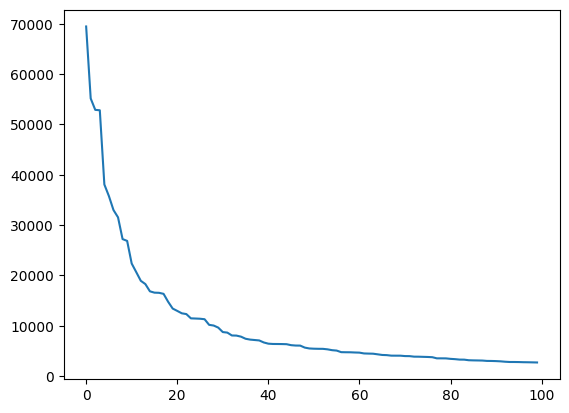

In [50]:
import matplotlib.pyplot as plt
%matplotlib inline
first_100_freqs = [freq for word, freq in freq_dict_sorted[:100]]
plt.plot(first_100_freqs)
plt.show()

Закон Хипса -- обратная сторона закона Ципфа. Он описывает, что чем больше корпус, тем меньше новых слов добавляется с добавлением новых текстов. В какой-то момент корпус насыщается.

## Задание 1.

**Задание**: обучите три классификатора: 

1) на токенах с высокой частотой 

2) на токенах со средней частотой 

3) на токенах с низкой частотой

Сравните полученные результаты, оцените какие токены наиболее важные для классификации.

Создадим корпус по тренировочным данным и отсортируем по частотам

In [51]:
corpus = [token for tweet in x_train for token in word_tokenize(tweet) if token not in punctuation]
print(len(corpus))
corpus[:10]

2152311


['reg_biryukova',
 'портрет',
 'который',
 'я',
 'рисовала',
 'еще',
 'летом',
 'с',
 'фотки',
 'какой-то']

In [52]:
freq_dict = Counter(corpus)
freq_dict_sorted = sorted(freq_dict.items(), key=lambda x: -x[1])
list(freq_dict_sorted)[:10]

[('не', 51978),
 ('и', 41337),
 ('в', 39724),
 ('я', 39595),
 ('RT', 28558),
 ('на', 26672),
 ('http', 24893),
 ('что', 23686),
 ('с', 20441),
 ('а', 20091)]

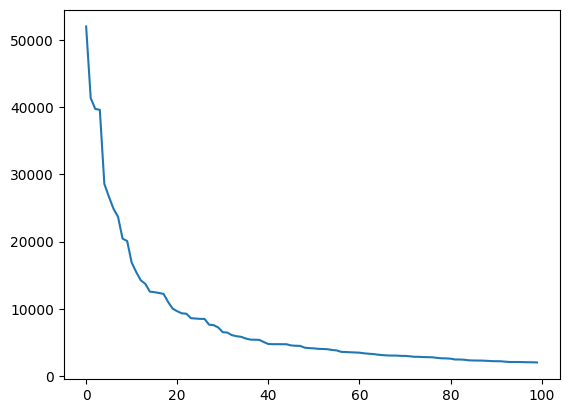

In [53]:
import matplotlib.pyplot as plt
%matplotlib inline
first_100_freqs = [freq for word, freq in freq_dict_sorted[:100]]
plt.plot(first_100_freqs)
plt.show()

Получим частоты

In [54]:
freqs = [freq for word, freq in freq_dict_sorted]

Найдем такие пороги, чтобы модели встречали одинаковое количество раз слова из своих словарей

In [55]:
sum_freqs = 0
flag_1 = True
for i in range(len(freqs)):
    sum_freqs+=freqs[i]
    if flag_1:
        if sum_freqs>=(sum(freqs)*1/3):
            threshold_token_1 = i
            flag_1 = False
    if sum_freqs>=(sum(freqs)*2/3):
        threshold_token_2 = i
        break
print(threshold_token_1)
print(threshold_token_2)

73
3075


Посмотрим на крайние токены:

In [56]:
print(freq_dict_sorted[threshold_token_1])
print(freq_dict_sorted[threshold_token_2])

('Не', 2871)
('всякий', 57)


Получим слова

In [57]:
freq_sorted_words = [word for word, freq in freq_dict_sorted]

 ## 1) на токенах с высокой частотой

In [58]:
high_freq_tokens = freq_sorted_words[:threshold_token_1]

In [59]:
high_freq_tokens[:10]

['не', 'и', 'в', 'я', 'RT', 'на', 'http', 'что', 'с', 'а']

In [60]:
vec = CountVectorizer(ngram_range=(1, 1), tokenizer=nltk.word_tokenize, stop_words=list(punctuation), vocabulary=high_freq_tokens)
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.57      0.62      0.59     25474
    positive       0.67      0.61      0.64     31235

    accuracy                           0.62     56709
   macro avg       0.62      0.62      0.62     56709
weighted avg       0.62      0.62      0.62     56709



 ## 2) на токенах со средней частотой

In [61]:
medium_freq_tokens = freq_sorted_words[threshold_token_1:threshold_token_2]

In [62]:
medium_freq_tokens[:10]

['Не', 'всё', 'сейчас', 'буду', '....', 'Как', 'У', 'знаю', 'тут', 'без']

In [63]:
vec = CountVectorizer(ngram_range=(1, 1), tokenizer=nltk.word_tokenize, stop_words=list(punctuation), vocabulary=medium_freq_tokens)
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.64      0.71      0.67     24996
    positive       0.75      0.68      0.71     31713

    accuracy                           0.69     56709
   macro avg       0.69      0.70      0.69     56709
weighted avg       0.70      0.69      0.69     56709



### 3) на токенах с низкой частотой

In [64]:
low_freq_tokens = freq_sorted_words[threshold_token_2:]

In [65]:
low_freq_tokens[:10]

['всякий',
 'оставить',
 'зная',
 'Последняя',
 '45',
 'СЕГОДНЯ',
 'реву',
 'останусь',
 'мешает',
 'пиццу']

In [66]:
vec = CountVectorizer(ngram_range=(1, 1), tokenizer=nltk.word_tokenize, stop_words=list(punctuation), vocabulary=low_freq_tokens)
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.77      0.67      0.71     32379
    positive       0.62      0.73      0.67     24330

    accuracy                           0.69     56709
   macro avg       0.70      0.70      0.69     56709
weighted avg       0.71      0.69      0.70     56709



### Вывод:
1). В пером случае у нас маленький словарь и большинство слов, это шум, который не несёт большой смысловой нагрузки  
2). Во-второй интервал вошли как шум, так и слова, имеющие более глубокий смысл. Метрики уже лучше. Но negative немного уступает positive.  
3). В третий интервал слова шум уже не попали. Accuracy выше, чем в предыдущих интервалах. Но здесь наоборот, класс positive предсказывается хуже negative.

## О важности эксплоративного анализа

Но иногда пунктуация бывает и не шумом -- главное отталкиваться от задачи. Что будет если вообще не убирать пунктуацию?

In [67]:
vec = TfidfVectorizer(ngram_range=(1, 1), tokenizer=word_tokenize)
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       1.00      1.00      1.00     28014
    positive       1.00      1.00      1.00     28695

    accuracy                           1.00     56709
   macro avg       1.00      1.00      1.00     56709
weighted avg       1.00      1.00      1.00     56709



Шок! Стоило оставить пунктуацию - и все метрики равны 1. Как это получилось? Среди неё были очень значимые токены (как вы думаете, какие?). Найдите фичи с самыми большими коэффициентами:

## Задание 2.

Найти фичи с наибольшей значимостью, и вывести их

О том насколько влияют токены нам скажут их веса, чем они больше в абсолютном значении, тем большее влияние у токена

In [68]:
dict_coef = list(zip(clf.coef_[0], range(len(clf.coef_[0]))))
dict_coef[:5]

[(-0.0024840910069232535, 0),
 (0.37614198282656336, 1),
 (-0.06780228496619159, 2),
 (1.1918633095203615, 3),
 (-0.2486369602924179, 4)]

In [69]:
dict_coef_sorted = sorted(dict_coef, key=(lambda x: -abs(x[0])))
dict_coef_sorted[:5]

[(-59.65181690013905, 7),
 (58.44868075226079, 8),
 (26.902344111633397, 43457),
 (-11.323374960749085, 101470),
 (-10.811896767830275, 180132)]

In [70]:
list(vec.vocabulary_.items())[:5]

[('@', 29513),
 ('reg_biryukova', 83260),
 ('портрет', 201102),
 (',', 100),
 ('который', 156761)]

In [71]:
vec_vocabulary_reverse = {y:x for x, y in vec.vocabulary_.items()}
list(vec_vocabulary_reverse.items())[:5]

[(29513, '@'),
 (83260, 'reg_biryukova'),
 (201102, 'портрет'),
 (100, ','),
 (156761, 'который')]

In [72]:
vocabulary_sorted = [vec_vocabulary_reverse[y] for x,y in dict_coef_sorted]
vocabulary_sorted[:10]

['(', ')', 'd', '|', 'о_о', 'dd', '^_^', '-/', 'o_o', 'ddd']

In [73]:
cool_token = ')'
pred = ['positive' if cool_token in tweet else 'negative' for tweet in x_test]
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       1.00      0.85      0.92     32914
    positive       0.83      1.00      0.91     23795

    accuracy                           0.91     56709
   macro avg       0.92      0.93      0.91     56709
weighted avg       0.93      0.91      0.92     56709



**Вывод:**  
В задаче Sentiment analysis огромную роль играют эмотиконы, а значит и символы(знаки пунктуации) из которых их часто состоявляют

## Символьные n-граммы

Теперь в качестве фичей используем, например, униграммы символов:

In [74]:
vec = CountVectorizer(analyzer='char', ngram_range=(1, 1))
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.99      1.00      0.99     27966
    positive       1.00      0.99      0.99     28743

    accuracy                           0.99     56709
   macro avg       0.99      0.99      0.99     56709
weighted avg       0.99      0.99      0.99     56709



В общем-то, теперь уже понятно, почему на этих данных здесь 1 (или почти 1). Так или иначе, на символах классифицировать тоже можно: для некоторых задач (например, для определения языка) фичи-символьные n-граммы решительно рулят.

Ещё одна замечательная особенность фичей-символов: токенизация и лемматизация не нужна, можно использовать такой подход для языков, у которых нет готовых анализаторов.

## Задание 3.

###  1). сравнить count/tf-idf/hashing векторайзеры/полносвязанную сетку (построить classification_report)

CountVectorizer

In [75]:
vec = CountVectorizer(ngram_range=(1, 1), tokenizer=nltk.word_tokenize, stop_words=noise)
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.80      0.77      0.78     29234
    positive       0.76      0.80      0.78     27475

    accuracy                           0.78     56709
   macro avg       0.78      0.78      0.78     56709
weighted avg       0.78      0.78      0.78     56709



TfidfVectorizer

In [76]:
vec = TfidfVectorizer(ngram_range=(1, 1), tokenizer=nltk.word_tokenize, stop_words=noise)
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.77      0.78      0.77     27670
    positive       0.79      0.78      0.78     29039

    accuracy                           0.78     56709
   macro avg       0.78      0.78      0.78     56709
weighted avg       0.78      0.78      0.78     56709



HashingVectorizer

In [77]:
from sklearn.feature_extraction.text import HashingVectorizer

In [79]:
hashing_n_features = 100

In [80]:
vec = HashingVectorizer(ngram_range=(1, 1), tokenizer=nltk.word_tokenize, stop_words=noise, n_features=hashing_n_features)
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.61      0.59      0.60     28931
    positive       0.59      0.61      0.60     27778

    accuracy                           0.60     56709
   macro avg       0.60      0.60      0.60     56709
weighted avg       0.60      0.60      0.60     56709



Neural network

Предобработка данных:

In [81]:
corpus = [token for tweet in x_train for token in word_tokenize(tweet) if token not in noise]
print(len(corpus))
corpus[:5]

1503624


['reg_biryukova', 'портрет', 'который', 'рисовала', 'летом']

In [82]:
freq_dict = Counter(corpus)
freq_dict_sorted= sorted(freq_dict.items(), key=lambda x: -x[1])
list(freq_dict_sorted)[:10]

[('RT', 28558),
 ('http', 24893),
 ('...', 16875),
 ('D', 12482),
 ('это', 12360),
 ("''", 9338),
 ('Я', 9279),
 ('``', 8616),
 ('..', 8514),
 ('А', 6478)]

In [83]:
vocabulary_size = len(freq_dict)
VOCABULARY_SIZE = vocabulary_size
VOCABULARY_SIZE

288501

In [84]:
top_n_words = [word for word, freq in freq_dict_sorted[:VOCABULARY_SIZE]]
top_n_words[:5]

['RT', 'http', '...', 'D', 'это']

In [85]:
vocab = {y:x for x,y in enumerate(top_n_words, start=1)}
list(vocab.items())[:5]

[('RT', 1), ('http', 2), ('...', 3), ('D', 4), ('это', 5)]

In [86]:
x_train_nn = x_train.apply(lambda text: [vocab.get(word, 0) for word in nltk.word_tokenize(text) if word not in noise])
x_test_nn = x_test.apply(lambda text: [vocab.get(word, 0) for word in nltk.word_tokenize(text) if word not in noise])
x_train_nn[:5]

86125              [91570, 8024, 127, 9326, 893, 369, 340]
86057    [7, 8436, 3, 1528, 14254, 3, 95, 31411, 9, 315...
22308    [218, 786, 130, 1221, 623, 10, 26, 73, 2321, 290]
67698            [1, 31412, 17284, 706, 1056, 1389, 55521]
90046                          [1, 55522, 326, 107, 13092]
Name: text, dtype: object

In [87]:
max_len = x_train_nn.apply(lambda txt: len(txt)).max()
MAX_LEN = max_len
MAX_LEN

40

In [88]:
x_train_nn = x_train_nn.apply(lambda x: x+[0]*(MAX_LEN-len(x)))
x_test_nn = x_test_nn.apply(lambda x: x+[0]*(MAX_LEN-len(x)))
x_train_nn[:5]

86125    [91570, 8024, 127, 9326, 893, 369, 340, 0, 0, ...
86057    [7, 8436, 3, 1528, 14254, 3, 95, 31411, 9, 315...
22308    [218, 786, 130, 1221, 623, 10, 26, 73, 2321, 2...
67698    [1, 31412, 17284, 706, 1056, 1389, 55521, 0, 0...
90046    [1, 55522, 326, 107, 13092, 0, 0, 0, 0, 0, 0, ...
Name: text, dtype: object

In [89]:
x_train_nn_array = np.array([j for j in [i for i in x_train_nn]])
x_test_nn_array = np.array([j for j in [i for i in x_test_nn]])
x_train_nn_array[0]

array([91570,  8024,   127,  9326,   893,   369,   340,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0])

In [90]:
y_train_nn = y_train.apply(lambda x: 1 if x=='positive' else 0)
y_test_nn = y_test.apply(lambda x: 1 if x=='positive' else 0)
y_train_nn[:5]

86125    1
86057    0
22308    1
67698    0
90046    0
Name: label, dtype: int64

Модель:

In [91]:
# !pip install tensorflow

In [92]:
import tensorflow as tf

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, Conv1D, GlobalAveragePooling1D, BatchNormalization, Dropout

2023-04-08 07:57:10.416540: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-08 07:57:10.453269: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-08 07:57:10.453639: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-08 07:57:11.234772: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [93]:
embedding_dim = 32
hidden_dim = 16
dropout = 0.2

In [94]:
model = Sequential([
    Embedding(VOCABULARY_SIZE+1, embedding_dim), # VOCABULARY_SIZE+1 так как еще 0, который показывает где нет слова
    BatchNormalization(),
    Dropout(dropout),

    GlobalAveragePooling1D(),

    Dense(hidden_dim, activation='relu'),
    Dense(1, activation='sigmoid')
])

2023-04-08 07:57:11.734216: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-08 07:57:11.734704: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [95]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

Обучение

In [96]:
hh = model.fit(x_train_nn_array, y_train_nn, epochs=2, batch_size=128)

Epoch 1/2
1330/1330 [==============================] - 132s 99ms/step - loss: 0.5004 - accuracy: 0.7435
Epoch 2/2
1330/1330 [==============================] - 132s 99ms/step - loss: 0.2746 - accuracy: 0.8826


In [97]:
nn_preds = model.predict(x_test_nn_array)
nn_preds[:5]

1773/1773 [==============================] - 1s 660us/step


array([[0.6041726 ],
       [0.40202722],
       [0.13869362],
       [0.67023736],
       [0.1535489 ]], dtype=float32)

Так как классы сбалансированны, то порог можно взять 0.5

In [98]:
threshold = 0.5

In [99]:
nn_preds_bin = (nn_preds > threshold).astype(int)
nn_preds_bin[:5]

array([[1],
       [0],
       [0],
       [1],
       [0]])

In [100]:
print(classification_report(nn_preds_bin, y_test_nn))

              precision    recall  f1-score   support

           0       0.69      0.80      0.74     24168
           1       0.83      0.73      0.78     32541

    accuracy                           0.76     56709
   macro avg       0.76      0.77      0.76     56709
weighted avg       0.77      0.76      0.76     56709



**Вывод:**  
Строить нейронную сеть и препроцессить для неё данные долго, еще дольше только подбирать параметры и обучать её, а результат считай такой же, но это я не использовал свёртки и res блоки.

HashingVectorizer быстрее остальных, но результаты хуже остальных, дальше буду подбирать количество признаков.

Результаты CountVectorizer и TfidfVectorizer почти одинаковые, но у TfidfVectorizer они более уравновешанные относительно классов. 

###  2). подобрать оптимальный размер для hashing векторайзера

In [101]:
n_features = [10, 100, 1000, 10000, 100000, 500000, 1000000]

In [102]:
res = []
for features in n_features:
  start_time = time.time()
  vec = HashingVectorizer(ngram_range=(1, 1), tokenizer=nltk.word_tokenize, stop_words=noise, n_features=features)
  bow = vec.fit_transform(x_train)
  clf = LogisticRegression(random_state=42)
  clf.fit(bow, y_train)
  pred = clf.predict(vec.transform(x_test))
  acc = (pred == y_test).sum() / len(y_test)
  print(f'n_features: {features}; acc: {acc}; time: {time.time()-start_time}')
  res.append({'n_features': features, 'acc': acc, 'time': (time.time()-start_time)})

n_features: 10; acc: 0.5434234424870832; time: 29.412506580352783
n_features: 100; acc: 0.5988114761325363; time: 29.4119131565094
n_features: 1000; acc: 0.6609709217231833; time: 29.57880663871765
n_features: 10000; acc: 0.7285792378634784; time: 30.180861234664917
n_features: 100000; acc: 0.7633708935089668; time: 35.03838849067688
n_features: 500000; acc: 0.770688955897653; time: 44.67604446411133
n_features: 1000000; acc: 0.770688955897653; time: 48.19840860366821


**Вывод**  
Чем больше мы возьмём параметров, тем лучше результат, но тем дольше обучается модель. Но разница по метрикам, например, между n_features = 100 и n_features = 1000 большая, а по времени маленькая, а вот для n_features = 100000 и n_features = 500000, наоборот, разница по метрики маленькая, а вот по времени большая.  
Таким образом, оптимальный размер для hashing векторайзера в нашем случае будет n_features = 100000.

###  3). убедиться что для сетки нет переобучения

In [103]:
nn_preds = model.predict(x_train_nn_array)
nn_preds[:5]

5317/5317 [==============================] - 3s 612us/step


array([[0.8770349 ],
       [0.11014671],
       [0.9931741 ],
       [0.04926991],
       [0.00415495]], dtype=float32)

In [104]:
threshold = 0.5

In [105]:
nn_preds_bin = (nn_preds > threshold).astype(int)
nn_preds_bin[:5]

array([[1],
       [0],
       [1],
       [0],
       [0]])

In [106]:
print(classification_report(nn_preds_bin, y_train_nn))

              precision    recall  f1-score   support

           0       0.90      0.98      0.94     77688
           1       0.98      0.91      0.95     92437

    accuracy                           0.94    170125
   macro avg       0.94      0.95      0.94    170125
weighted avg       0.95      0.94      0.94    170125



In [107]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          9232064   
                                                                 
 batch_normalization (BatchN  (None, None, 32)         128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, None, 32)          0         
                                                                 
 global_average_pooling1d (G  (None, 32)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dense_1 (Dense)             (None, 1)                 1

Метрики на train не равны все 1, что уже хорошо, они конечно больше на 0.2 чем метрики на test, поэтому можно сказать, что небольшое переобучение возможно. Но я и так тренировал всего 2 эпохи, взял маленькое количество нейронов для классификации и использовал batchnorm и dropout(0.2). 